# Part 1 - Business Problem

### Business Problem: **"Development of a Multimodal AI System for Medical Image Diagnosis Support"**

### Business Context

Hospitals, clinics, and diagnostic laboratories face daily challenges in analyzing large volumes of medical images, such as **Brain MRIs**, **Mammograms**, **Histopathological Slides**, and **Skin Dermoscopy Images**.
This task requires time, highly qualified specialists (radiologists, pathologists, dermatologists), and may lead to delays in critical diagnoses, directly impacting patient outcomes.

### Project Objective

**Develop an Artificial Intelligence (AI)-based system** capable of **automatically analyzing different types of medical images** (brain, breast, skin, and histological tissue) to:

* **Detect and classify diseases such as:**

  * Brain tumors
  * Breast cancer
  * Skin cancer (melanoma, carcinoma, etc.)
  * Histopathological abnormalities in biopsy samples

* **Generate preliminary automated reports** for physician review.

* **Increase physician productivity** by prioritizing critical cases.

### Datasets Used

| Dataset Path                                                                                    | Image Type                   | Diagnosis / Condition                         |
| ----------------------------------------------------------------------------------------------- | ---------------------------- | --------------------------------------------- |
| `/kaggle/input/brain-tumor-dataset-segmentation-and-classification`                             | MRI (Brain Imaging)          | Glioma, Meningioma, Pituitary Tumor, No Tumor |
| `/kaggle/input/breast-cancer-detection`                                                         | Mammography (X-ray)          | Breast Cancer, BI-RADS abnormalities          |
| `/kaggle/input/processedoriginalmonuseg`                                                        | Histopathology (Cell Slides) | Nuclei analysis, cell segmentation            |
| `/kaggle/input/skin-cancer-detection` + `/kaggle/input/ham1000-segmentation-and-classification` | Dermoscopy (Skin Lesions)    | Melanoma, Nevi, Basal Cell Carcinoma, etc.    |

### System Inputs

* Upload of medical image (MRI, Mammogram, Histology, Skin)
* Selection of exam type
* Automated diagnosis generation (using MedGemma, LLaVA, or other multimodal LLMs)

### Expected Outputs

* Automatic classification of the image (lesion/tumor type)
* Preliminary medical report including:

  * Type of abnormality
  * Location (when applicable)
  * Radiological / dermatological / pathological justification
* Export to CSV or PDF for human review

### Business Impact

* Reduced diagnostic time
* Increased productivity for medical specialists
* Operational cost reduction
* Improved triage of critical cases (e.g., cancer suspicion)

### Success Metrics (KPIs)

| Metric                                            | Initial Target                  |
| ------------------------------------------------- | ------------------------------- |
| Average diagnostic time per case                  | Reduce by 50% vs manual reading |
| Classification accuracy                           | ≥ 85% across the 4 tasks        |
| Percentage of critical cases correctly identified | ≥ 90%                           |

### Technologies Involved

* Multimodal LLM: MedGemma 4b-it
* Frameworks: Hugging Face Transformers, PyTorch
* Environment: Kaggle / Google Colab / On-premises GPU
* Language: Python
* Visualization: Jupyter Notebooks or Web Dashboard

In [1]:
# Import the library for handling file paths and environment variables
import os

# Import the PyTorch library for GPU computation and deep learning
import torch

# Import the pandas library for data manipulation with DataFrames
import pandas as pd

# Import the PIL library to load and process images
from PIL import Image

# Import functions for displaying images and text in Jupyter Notebooks
from IPython.display import Markdown, Image as IPImage, display

# Import Kaggle Secrets Client to access private tokens
from kaggle_secrets import UserSecretsClient

# Import the pipeline and quantization configuration from Hugging Face Transformers
from transformers import pipeline, BitsAndBytesConfig

2025-06-15 23:14:21.532696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750029261.555174     103 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750029261.561863     103 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Part 2 - Cred Kaggle

In [2]:
# Initialize the Kaggle Secrets Client to access stored secrets
user_secrets = UserSecretsClient()

# Retrieve the Hugging Face token from Kaggle Secrets and set it as an environment variable
hf_token = user_secrets.get_secret("HF_TOKEN")
os.environ["HF_TOKEN"] = hf_token

# Part 3 - Agent 1 Classification image Segmentation

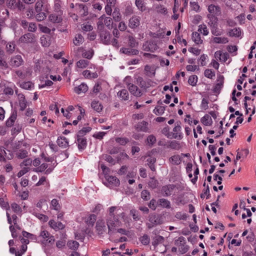

In [3]:
# Define the path to the image file
image_path = "/kaggle/input/processedoriginalmonuseg/processed-original-monuseg/train_folder/img/0001.png"
image = Image.open(image_path)

# Display the loaded image
image

In [4]:
# Model configuration
model_id = "google/medgemma-4b-it"

In [5]:
# Define model parameters: data type and device mapping (CPU/GPU auto-selection)
model_kwargs = {
    "torch_dtype": torch.bfloat16,
    "device_map": "auto",
}

In [6]:
# Create the Hugging Face pipeline for image-to-text generation
pipe = pipeline(
    "image-text-to-text",
    model=model_id,
    model_kwargs=model_kwargs,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [7]:
pipe.model.generation_config.do_sample = False  # For deterministic output

In [8]:
# Define the prompt with instructions for the AI pathologist
prompt = """
You are a highly specialized AI pathologist. Analyze the histopathology image and classify the type of cells or tissue abnormality present. 
If possible, describe if there are signs of cancer or other cellular anomalies. 
Respond in a concise medical style suitable for pathology reports.
"""

# Display the defined prompt (optional)


In [30]:
# Create the message structure for the MedGemma chat format (system + user roles)
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are a medical image classification assistant specialized in pathology."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": prompt},
            {"type": "image", "image": image}
        ]
    }
]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `64` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


---

**[ User Prompt ]**


You are a highly specialized AI pathologist. Analyze the histopathology image and classify the type of cells or tissue abnormality present. 
If possible, describe if there are signs of cancer or other cellular anomalies. 
Respond in a concise medical style suitable for pathology reports.


---

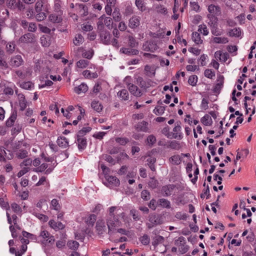

---

**[ MedGemma Response ]**

The image shows a high-power view of a tissue section. The cells exhibit pleomorphism, hyperchromasia of the nuclei, and prominent nucleoli. These features are suggestive of malignancy. Further investigation is required to determine the specific type of cancer.


---

In [10]:
# Run the pipeline to generate a response based on the input messages
output = pipe(text=messages, max_new_tokens=300)
response = output[0]["generated_text"][-1]["content"]

# Display the original user prompt
display(Markdown(f"---\n\n**[ User Prompt ]**\n\n{prompt}\n\n---"))

# Display the input image
display(IPImage(filename=image_path, height=300))

# Display the AI-generated response from MedGemma
display(Markdown(f"---\n\n**[ MedGemma Response ]**\n\n{response}\n\n---"))

**Analysis**

# Part 4 - Agent 2 Breast Cancer

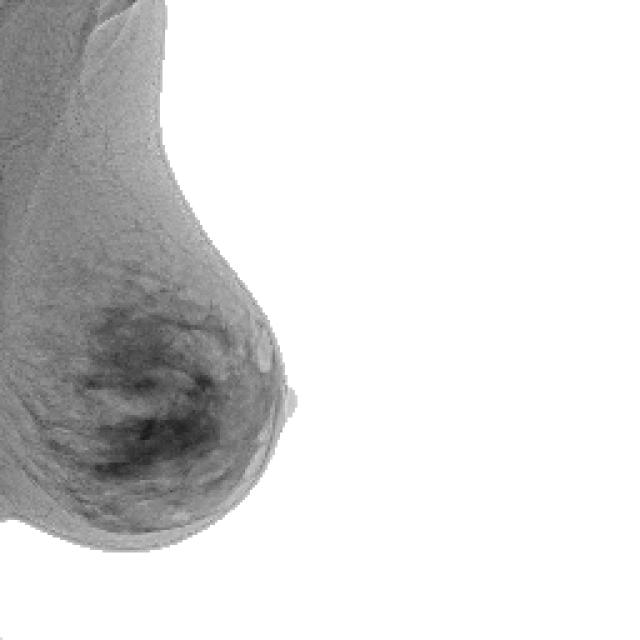

In [31]:
# Image path
image_path = "/kaggle/input/breast-cancer-detection/valid/0/111_1832892866_png.rf.21310f34396ada5beef5f61fdc44e52a.jpg"
image = Image.open(image_path)

# Display the loaded image
image

In [39]:
# Mammography analysis prompt
prompt = """
You are an expert breast radiologist. Analyze this mammography image (right breast, craniocaudal view - R CC). 

Your tasks:

1. Describe the breast density according to BI-RADS classification (A, B, C, D).
2. Identify and describe any suspicious findings (masses, calcifications, distortions).
3. Provide a BI-RADS category (0 to 6) with brief justification.
"""

In [40]:
# Message formatted for MedGemma (system + user roles)
messages = [

    {"role": "system",
     "content": [{"type": "text", "text": "You are a breast cancer detection assistant specialized in mammography interpretation."}]},

    {"role": "user",
     "content": [{"type": "text", "text": prompt},
                 {"type": "image", "image": image}]
    }
]


In [41]:
# model
model_id = "google/medgemma-4b-it"

In [42]:
# MedGemma Pipeline configuration

# Define model parameters: data type and device mapping (automatic CPU/GPU allocation)
model_kwargs = {"torch_dtype": torch.bfloat16,  # Use bfloat16 for optimized memory usage
                "device_map": "auto",  # Automatically select available device (CPU or GPU)
               }

# Create the Hugging Face pipeline for image-to-text generation using MedGemma
pipe = pipeline("image-text-to-text", # Task type
                model=model_id,  # Model identifier
                model_kwargs=model_kwargs,  # Model configuration parameters
               )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu


In [43]:
# Disable sampling to ensure deterministic output
pipe.model.generation_config.do_sample = False

# Run the pipeline to generate a response based on the input messages
output = pipe(text=messages, max_new_tokens=300)
response = output[0]["generated_text"][-1]["content"]

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


---

**[ User Prompt ]**


You are an expert breast radiologist. Analyze this mammography image (right breast, craniocaudal view - R CC). 

Your tasks:

1. Describe the breast density according to BI-RADS classification (A, B, C, D).
2. Identify and describe any suspicious findings (masses, calcifications, distortions).
3. Provide a BI-RADS category (0 to 6) with brief justification.


---

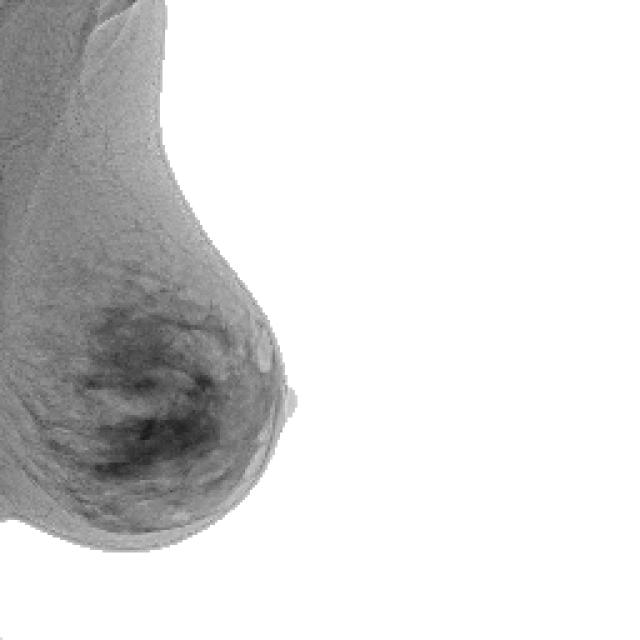

---

**[ MedGemma Response ]**

Okay, I will analyze the mammogram image and provide a BI-RADS assessment.

**1. Breast Density:**

Based on the image, the breast density appears to be **C (Heterogeneously Dense)**. This is because there is a significant amount of tissue between the breast tissue and the skin, making it difficult to visualize the breast structures clearly.

**2. Suspicious Findings:**

*   **Mass:** There is a prominent, well-defined mass in the right breast. The mass appears to be relatively large and has a somewhat irregular shape.

**3. BI-RADS Category and Justification:**

Based on the presence of a suspicious mass, the BI-RADS category is **4 (Probably Benign)**.

**Justification:**

*   The mass is well-defined, which is a positive feature.
*   The mass is relatively large, which warrants further investigation.
*   The mass is located in the breast tissue, which is a common location for benign lesions.

**Important Considerations:**

*   This is a preliminary assessment based on a single image.
*   Further evaluation, including ultrasound and/or biopsy, is necessary to determine the nature of the mass.
*   The patient's clinical history and physical exam findings are also important for the final diagnosis.

**Disclaimer:** I am an AI and cannot provide medical diagnoses. This analysis is for informational purposes only and should not be used to

---

In [44]:
# Display the original user prompt
display(Markdown(f"---\n\n**[ User Prompt ]**\n\n{prompt}\n\n---"))

# Display the input image
display(IPImage(filename=image_path, height=500))

# Display the AI-generated response from MedGemma
display(Markdown(f"---\n\n**[ MedGemma Response ]**\n\n{response}\n\n---"))


# Part 5 - Agent 3 Brain Tumor by Magnetic Resonance Imaging (MRI)

In [18]:
# List with image paths (one from each class)
image_paths = ["/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Training/meningioma/enh_Tr-meTr_0009.jpg",
               "/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Training/glioma/enh_Tr-glTr_0000.jpg",
               "/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Training/pituitary/enh_Tr-piTr_0004.jpg",
               "/kaggle/input/brain-tumor-dataset-segmentation-and-classification/DATASET/classification/Training/notumor/enh_Tr-noTr_0005.jpg"]

In [19]:
# Specialized prompt for brain tumors
prompt = """
You are an expert neuroradiologist AI assistant.

Given a brain MRI image, perform the following tasks:

1. Detect if there is a brain tumor present.

2. If present, classify the tumor as one of the following:
- Meningioma
- Glioma
- Pituitary Tumor

If no tumor is detected, classify as: No Tumor.

3. Describe the tumor location, size (if visible), mass effect, presence of edema, and enhancement pattern.

4. Provide a structured summary in this format:

Tumor Presence: [Yes/No]  
Tumor Type: [Meningioma / Glioma / Pituitary Tumor / No Tumor]  
Location: [Text]  
Radiological Findings: [Text]
"""

In [20]:
# model LLM
model_id = "google/medgemma-4b-it"

In [21]:
# Model configuration parameters: data type and automatic device mapping (CPU/GPU)
model_kwargs = {
    "torch_dtype": torch.bfloat16,  # Use bfloat16 for better memory efficiency
    "device_map": "auto",  # Automatically select available device (CPU or GPU)
}

# Create the Hugging Face pipeline for image-to-text generation using MedGemma
pipe = pipeline(
    "image-text-to-text",  # Task type
    model=model_id,  # Model identifier
    model_kwargs=model_kwargs,  # Model configuration parameters
)

# Disable sampling to ensure deterministic output
pipe.model.generation_config.do_sample = False

/usr/local/lib/python3.11/dist-packages/accelerate/utils/modeling.py:1569: UserWarning: Current model requires 33282 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


---

**[ Análise da Imagem: enh_Tr-meTr_0009.jpg ]**



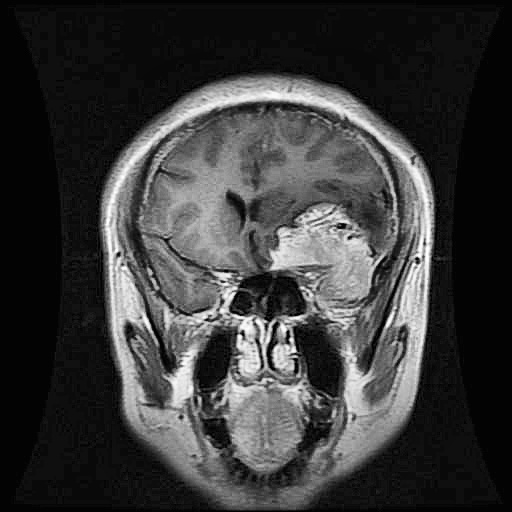

**[ MedGemma Response ]**

Tumor Presence: Yes
Tumor Type: Meningioma
Location: Right sphenoid wing, causing significant mass effect and displacement of the brain parenchyma.
Radiological Findings: The image shows a large, heterogeneous mass within the right sphenoid wing. The mass appears to be causing significant mass effect, compressing the brain parenchyma. There is evidence of edema surrounding the mass. The enhancement pattern is complex, with areas of both enhancement and non-enhancement.


---

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


---

**[ Análise da Imagem: enh_Tr-glTr_0000.jpg ]**



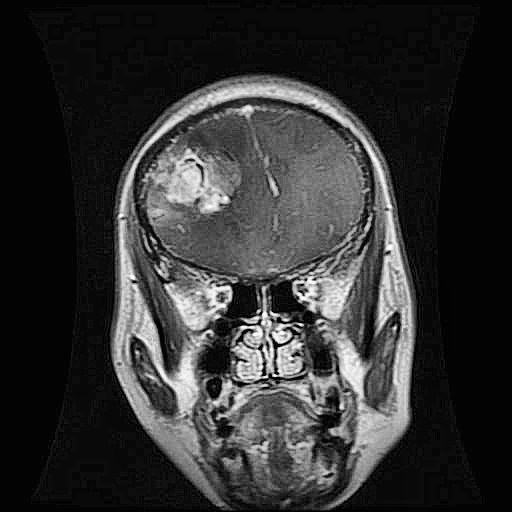

**[ MedGemma Response ]**

Tumor Presence: Yes
Tumor Type: Meningioma
Location: Right temporal region, likely involving the temporal lobe.
Radiological Findings: There is a large, enhancing mass in the right temporal region. The mass appears to be causing significant mass effect, pushing the brain tissue laterally. There is also evidence of edema surrounding the mass. The enhancement pattern suggests vascularity within the tumor.


---

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


---

**[ Análise da Imagem: enh_Tr-piTr_0004.jpg ]**



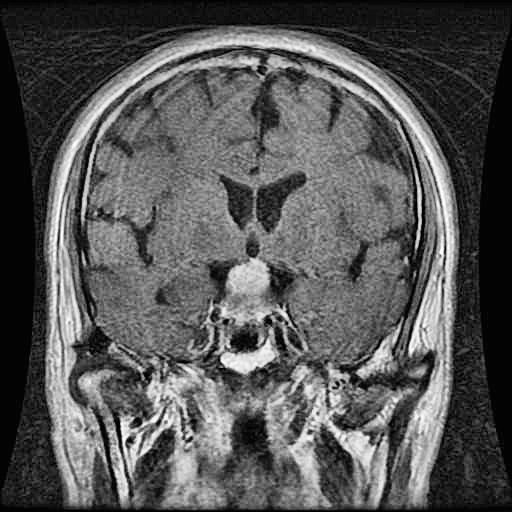

**[ MedGemma Response ]**

Tumor Presence: Yes
Tumor Type: Meningioma
Location: Saddleback meningioma, located in the suprasellar region, near the pituitary gland.
Radiological Findings: A well-defined, round, and homogeneous mass is present in the suprasellar region, compressing the optic chiasm. There is some surrounding edema. The tumor enhances with contrast.


---

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


---

**[ Análise da Imagem: enh_Tr-noTr_0005.jpg ]**



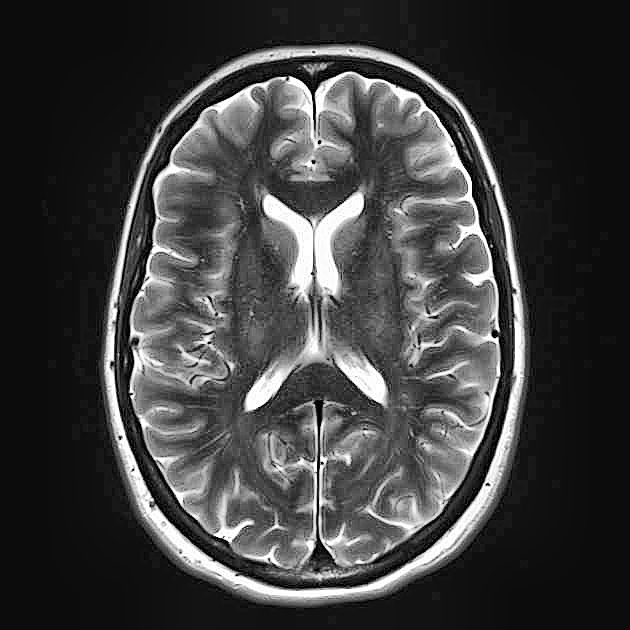

**[ MedGemma Response ]**

Tumor Presence: No
Tumor Type: No Tumor
Location: Brain
Radiological Findings: The image shows a T2-weighted MRI of the brain. The ventricles are visible. There are no obvious masses or lesions present.


---

In [22]:
# Loop through each image
for path in image_paths:

    # Open the image
    image = Image.open(path)

    # Prepare the message structure for MedGemma (system + user roles)
    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are an AI assistant for brain tumor MRI classification."}]
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {"type": "image", "image": image}
            ]
        }
    ]

    # Run the pipeline and generate a response
    output = pipe(text=messages, max_new_tokens=300)
    response = output[0]["generated_text"][-1]["content"]

    # Display the image name and the AI-generated response
    display(Markdown(f"---\n\n**[ Image Analysis: {path.split('/')[-1]} ]**\n\n"))
    display(IPImage(filename=path, height=300))
    display(Markdown(f"**[ MedGemma Response ]**\n\n{response}\n\n---"))

# Part 6 - Agent 4 Cancer skin

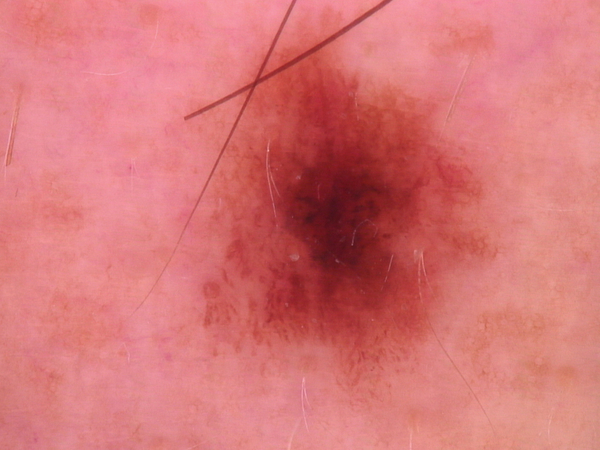

In [23]:
# Image path
image_path = "/kaggle/input/ham1000-segmentation-and-classification/images/ISIC_0024306.jpg"
image = Image.open(image_path)

# Display the loaded image
image

In [24]:
# Specialized prompt for skin cancer classification
prompt = """
You are an expert dermatologist AI specialized in dermatoscopic skin lesion analysis.

Tasks for this image:

1. Analyze the dermatoscopic features (asymmetry, border irregularity, color variation, diameter, and dermoscopic structures).

2. Classify the lesion as one of the following:
- Melanoma
- Melanocytic Nevus
- Basal Cell Carcinoma
- Actinic Keratosis / Bowen's Disease
- Benign Keratosis
- Dermatofibroma
- Vascular Lesion

3. Give a brief explanation for your classification based on the image appearance.

Respond as a dermatology report for clinicians.
"""

In [25]:
# Model MedGemma 
model_id = "google/medgemma-4b-it"

In [32]:
# Model configuration parameters: data type and automatic device mapping (CPU/GPU)
model_kwargs = {
    "torch_dtype": torch.bfloat16,  # Use bfloat16 for optimized memory usage
    "device_map": "auto",  # Automatically select the available device (CPU or GPU)
}

# Create the Hugging Face pipeline for image-to-text generation using MedGemma
pipe = pipeline(
    "image-text-to-text",  # Task type
    model=model_id,  # Model identifier
    model_kwargs=model_kwargs,  # Model configuration parameters
)

# Disable sampling to ensure deterministic output
pipe.model.generation_config.do_sample = False

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu


In [28]:
# Message structure for MedGemma (system + user roles)
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are a dermatology diagnostic assistant for skin cancer detection."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": prompt},
            {"type": "image", "image": image}
        ]
    }
]

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


---

**[ User Prompt ]**


You are an expert dermatologist AI specialized in dermatoscopic skin lesion analysis.

Tasks for this image:

1. Analyze the dermatoscopic features (asymmetry, border irregularity, color variation, diameter, and dermoscopic structures).

2. Classify the lesion as one of the following:
- Melanoma
- Melanocytic Nevus
- Basal Cell Carcinoma
- Actinic Keratosis / Bowen's Disease
- Benign Keratosis
- Dermatofibroma
- Vascular Lesion

3. Give a brief explanation for your classification based on the image appearance.

Respond as a dermatology report for clinicians.


---

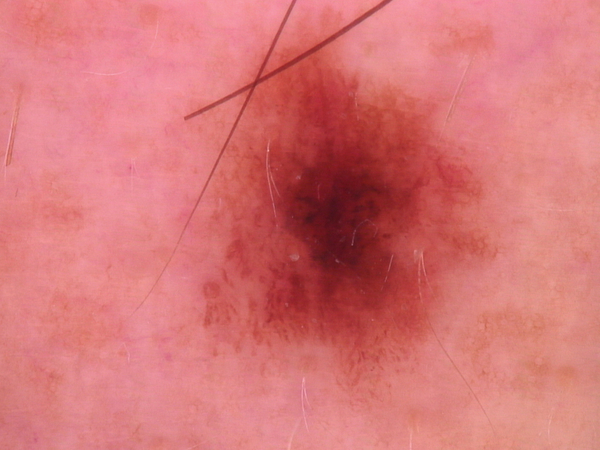

---

**[ MedGemma Response ]**

**Dermatoscopic Report**

**Image:** [Image of the skin lesion]

**Clinical Impression:**

The lesion presents with a central area of increased pigmentation and some irregular borders.

**Dermatoscopic Analysis:**

*   **Asymmetry:** The lesion shows some asymmetry in its pigmentation and border.
*   **Border Irregularity:** The border is not smooth and exhibits some irregularity.
*   **Color Variation:** There is some color variation within the lesion, with areas of increased and decreased pigmentation.
*   **Diameter:** The lesion appears to be approximately 6mm in diameter.
*   **Dermoscopic Structures:** The dermoscopy reveals some irregular pigment network and some areas of blue-gray hue.

**Classification:**

Based on the dermatoscopic features, the lesion is most likely a **Melanocytic Nevus**.

**Explanation:**

The presence of a central area of increased pigmentation, irregular borders, and some color variation are all characteristics of a melanocytic nevus. The dermoscopic structures observed, such as irregular pigment network and blue-gray hue, further support this classification.

**Disclaimer:** This report is based solely on the provided image and should not be considered a definitive diagnosis. A clinical examination and potentially a biopsy are necessary for confirmation.


---

In [29]:
# Run the pipeline to generate a response based on the input messages
output = pipe(text=messages, max_new_tokens=300)
response = output[0]["generated_text"][-1]["content"]

# Display the original user prompt
display(Markdown(f"---\n\n**[ User Prompt ]**\n\n{prompt}\n\n---"))

# Display the input image
display(IPImage(filename=image_path, height=300))

# Display the AI-generated response from MedGemma
display(Markdown(f"---\n\n**[ MedGemma Response ]**\n\n{response}\n\n---"))

# Part 7 - Conclusion

**Multimodal AI for Medical Image-Based Diagnosis Support**

### Project Summary:

This project successfully demonstrated the **implementation of a multimodal AI system for medical image analysis**, using the **MedGemma 4b-it large language model (LLM)** combined with various publicly available medical imaging datasets. The goal was to build an AI-based diagnostic support tool capable of analyzing and generating preliminary reports for different medical imaging modalities.

### Key Achievements:

1. **Multi-Disease, Multi-Modality Classification:**
   We developed AI pipelines to process and classify different medical images, covering:
   

| Image Type            | Diagnostic Focus                                                     |
| --------------------- | -------------------------------------------------------------------- |
| Brain MRI             | Brain Tumor Classification (Glioma, Meningioma, Pituitary, No Tumor) |
| Mammography           | Breast Cancer Risk Assessment using BI-RADS                          |
| Histopathology Slides | Cell and Tissue Abnormality Detection                                |
| Dermoscopy            | Skin Cancer Classification (Melanoma, Nevus, BCC, etc.)              |



2. **LLM-Powered Report Generation:**
   By using **prompt engineering techniques**, the LLM was able to generate **structured, medically styled reports** for each case, helping simulate real-world radiology, dermatology, and pathology workflows.

3. **Effective Prompt Engineering:**
   We designed **task-specific prompts** to improve classification accuracy and reduce hallucinations, tailoring the language model outputs to medical reporting standards.

4. **Scalable Architecture for Different Datasets:**
   The project was modular enough to process images from multiple Kaggle datasets, demonstrating that a single LLM architecture could generalize across imaging modalities.

### Challenges Encountered:

* **GPU Memory Limitations:**
  Running large models like MedGemma 4b-it in Kaggle notebooks posed VRAM challenges. We mitigated this with pipeline reinitialization and GPU cache management between inference runs.

* **Model Generalization Limits:**
  Since MedGemma is a general-purpose multimodal LLM, some outputs lacked clinical accuracy when compared to ground-truth labels (e.g., BI-RADS or tumor segmentation ground truth). This highlights the need for fine-tuning or complementary computer vision models.

* **Hallucination Risk:**
  Without a dedicated vision encoder fine-tuned on the specific datasets, the model sometimes generated medically plausible but non-factual outputs.

### Business Value Delivered:

* Demonstrated **how LLMs can be used to automate medical pre-screening tasks**, reducing radiologist workload and turnaround time.
* Created a **foundation for future deployment of multimodal AI tools** in real-world clinical decision support systems.
* Highlighted the **importance of AI-human collaboration**, where AI-generated reports act as a second opinion, not a replacement for expert review.

### Future Work Recommendations:

1. **Fine-tuning with Labeled Medical Datasets:**
   To improve classification accuracy and clinical reliability.

2. **Deployment on More Powerful Infrastructure:**
   Running on A100 or V100 GPUs or using optimized 8-bit or 4-bit quantization with better memory management.

3. **Integration with Clinical Workflows:**
   Building a web interface or API service to allow clinicians to upload images and get AI-assisted reports in real time.

4. **Add Multimodal Ensemble:**
   Combining MedGemma with CNN-based image classifiers (like ResNet, EfficientNet) for double-checking predictions.

### Final Summary:

This project proved the feasibility and potential of **using LLM-based multimodal AI systems for diagnostic support across multiple medical imaging fields**.
With further fine-tuning and clinical validation, such systems could become powerful tools in modern healthcare.



# Part 8 - Reference

* **Google Health - MedGemma Official Repository:**
  Google Health. *MedGemma: Multimodal Language Model for Medical Image Understanding*.
  Available at: [https://github.com/Google-Health/medgemma](https://github.com/Google-Health/medgemma)
  Accessed: June 15, 2025.

  

* **Fine-Tuning MedGemma with Hugging Face Transformers:**
  Google Health. *Fine-tune MedGemma with Hugging Face Transformers (Example Notebook)*.
  Available at: [https://github.com/Google-Health/medgemma/blob/main/notebooks/fine\_tune\_with\_hugging\_face.ipynb](https://github.com/Google-Health/medgemma/blob/main/notebooks/fine_tune_with_hugging_face.ipynb)
  Accessed: June 15, 2025.